In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import json
from scipy import sparse
from sklearn.linear_model import LinearRegression

### This notebook generates Fig. 4 in the manuscript

In [2]:
"""get the parking hours in each county of the Chicago Metropolitan Area"""

N_e = 11080
N_n = 7
N_t = 96

Chain_df = {}
for e in range(N_e):
    Chain_df[e] = pd.read_csv(f'TripChains/Chicago2017_Raw/Chain_df_{e}.csv', index_col = 0)

N_i = np.zeros(N_e)
for e in range(N_e):
    N_i[e] = Chain_df[e].shape[0]
N_i = N_i.astype(int)

q = pd.read_csv('TripChains/Chicago2017_Raw/flows.csv', index_col = 0).values.T[0]

with open('TripChains/Home_new_Chicago2017.txt', 'r') as f:
    homeNodes = json.load(f)


mapping = pd.read_csv('TripChains/county_Mapping.csv', index_col = 0)
mappings = {}
for i in range(len(mapping)):
    mappings[mapping['nodeIndex'][i]] = mapping['countyIndex'][i]
countyIndices = mapping['countyIndex'].unique()
countyNodes = {}
for n in range(len(countyIndices)):
    countyNodes[countyIndices[n]] = n

countyName = ['Cook', 'DuPage', 'Kane', 'Lake', 'McHenry', 'Will', 'Kendall']


home_node_rec = np.zeros(N_e)
for e in range(N_e):
    try:
        home_node_temp = np.where(np.array(homeNodes[e]) == 1)[0][-1]
        home_node_temp = Chain_df[e]['n^arr'].values[home_node_temp+1]
    except:
        home_node_temp = Chain_df[e]['n^arr'].values[0]
    home_node_rec[e] = int(countyNodes[mappings[home_node_temp]])

parkingDuration_home_county = np.zeros(N_n)
parkingSessionNum_home_county = np.zeros(N_n)
parkingDuration_nonhome_county = np.zeros(N_n)
parkingSessionNum_nonhome_county = np.zeros(N_n)

home_node_update = {}
for e in range(N_e):
    if Chain_df[e]['t^arr'].values[-1] < N_t - 1:
        start_charge, end_charge = np.zeros(N_i[e]), np.zeros(N_i[e])
        start_charge[:-1] = Chain_df[e]['t^arr'].values[:-1]
        end_charge[:-1] = Chain_df[e]['t^dep'].values[1:]
        start_charge[-1] = Chain_df[e]['t^arr'].values[-1]
        end_charge[-1] = N_t
        N_i_temp = N_i[e]
        homeNodes_e = homeNodes[e]
    else:
        start_charge, end_charge = np.zeros(N_i[e]-1), np.zeros(N_i[e]-1)
        start_charge = Chain_df[e]['t^arr'].values[:-1]
        end_charge = Chain_df[e]['t^dep'].values[1:]
        N_i_temp = N_i[e] - 1
        homeNodes_e = homeNodes[e][:-1]

    start_charge = start_charge.astype(int)
    end_charge = end_charge.astype(int)
    duration_charge = end_charge - start_charge
    location_charge = Chain_df[e]['n^arr'].values.astype(int)

    try:
        home_node_temp = np.where(np.array(homeNodes[e]) == 1)[0][-1]
        home_node_temp = Chain_df[e]['n^arr'].values[home_node_temp+1]
    except:
        home_node_temp = Chain_df[e]['n^arr'].values[0]

    home_node_update[e] = np.zeros(N_i_temp)
    home_node_update[e][1:] = homeNodes_e
    if home_node_temp == location_charge[0]:
        home_node_update[e][0] = 1

    for i in range(N_i_temp):
        countyID_temp = int(countyNodes[mappings[location_charge[i]]])
        
        if home_node_update[e][i] == 1:
            parkingDuration_home_county[countyID_temp] += duration_charge[i]/4*q[e]
            parkingSessionNum_home_county[countyID_temp] += q[e]
        else:
            parkingDuration_nonhome_county[countyID_temp] += duration_charge[i]/4*q[e]
            parkingSessionNum_nonhome_county[countyID_temp] += q[e]


# parkingSession_county = pd.DataFrame({
#     'sessionNum_home': parkingSessionNum_home_county,
#     'sessionNum_nonhome': parkingSessionNum_nonhome_county,
#     'duration_home': parkingDuration_home_county,
#     'duration_nonhome': parkingDuration_nonhome_county,
# }, index = countyName)

parkHours_Chicago = pd.DataFrame({
    'home': parkingDuration_home_county,
    'nonhome': parkingDuration_nonhome_county,
    'total': parkingDuration_home_county + parkingDuration_nonhome_county
}, index = countyName)

# parkingSession_county.to_csv('Results_plot/Chicago2017/parkingSession_county.csv')

parkHours_Chicago = parkHours_Chicago * 0.011 # account for the EV penetration

In [3]:
"""load the virtual battery capacity results of the Chicago Metropolitan Area"""
N_t = 96
N_n = 7
N_line = 6 

capacity_county = pd.read_csv('geo/capacity_county_ordered.csv', index_col = 0)['EV_LOAD_CAPACITY_KW'].values/1000 / 56.5 * 1000
peneNum = 10
capacityNum = 10
capacity_scale = np.arange(capacityNum) + 1
peneList = np.linspace(0.1, 1, peneNum)
peneList = [0.011]

ratio_pubCharger_list = np.linspace(0.4, 1, 7)
ratioNum = len(ratio_pubCharger_list)

u_UB_rec = {}
u_LB_rec = {}
E_UB_rec = {}
E_LB_rec = {}
f_UB_rec = {}
f_LB_rec = {}

for i in [0]:
    u_UB_rec[i] = {}
    u_LB_rec[i] = {}
    E_UB_rec[i] = {}
    E_LB_rec[i] = {}
    f_UB_rec[i] = {}
    f_LB_rec[i] = {}
    pene_value = peneList[i]
    path_temp = f'Results/Chicago2017_RealCapacity/VB_VL_realPene/pene={pene_value:.3f}'
    for ratio_pubCharger in ratio_pubCharger_list:
        u_UB_rec[i][ratio_pubCharger] = {}
        u_LB_rec[i][ratio_pubCharger] = {}
        E_UB_rec[i][ratio_pubCharger] = {}
        E_LB_rec[i][ratio_pubCharger] = {}
        f_UB_rec[i][ratio_pubCharger] = {}
        f_LB_rec[i][ratio_pubCharger] = {}
        for j in range(capacityNum):
            u_UB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/u_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()
            u_LB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/u_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()
            E_UB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/E_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()
            E_LB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/E_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()
            f_UB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/f_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()
            f_LB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/f_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()

            break # only one capacity scale
        break # only one ratio_pubCharger
    break # only one pene_value
           
BatteryPowerCapacity_Chicago = (u_UB_rec[i][ratio_pubCharger][j] - u_LB_rec[i][ratio_pubCharger][j]).mean(axis = 1)/1000 # GW
BatteryEnergyCapacity_Chicago = (E_UB_rec[i][ratio_pubCharger][j] - E_LB_rec[i][ratio_pubCharger][j]).mean(axis = 1)/1000 # GWh
            

In [4]:
"""calculate the parking hours of EVs in each county of the San Francisco Bay Area"""

N_n = 9
N_t = 96

batteryCapacity = 56.5 # kWh

index_to_county = {
    0: 'San Francisco',
    1: 'San Mateo',
    2: 'Santa Clara',
    3: 'Alameda',
    4: 'Contra Costa',
    5: 'Solano',
    6: 'Napa',
    7: 'Sonoma',
    8: 'Marin'
}


# 从 JSON 文件中读取字典
with open('TripChains/California_Raw/chain_select_bay.json', 'r') as f:
    Chain_df = json.load(f)


q = np.load('TripChains/California_Raw/flows_select_bay.npy')


index_to_county = {
    0: 'San Francisco',
    1: 'San Mateo',
    2: 'Santa Clara',
    3: 'Alameda',
    4: 'Contra Costa',
    5: 'Solano',
    6: 'Napa',
    7: 'Sonoma',
    8: 'Marin'
}


def calculate_parking_time_with_flows(filtered_chain, selected_flows):
    home_parking_times = {}  # 字典来存储每个county的home停车时间
    nonhome_parking_times = {}  # 字典来存储每个county的nonhome停车时间

    for chain_index, chain in enumerate(filtered_chain):
        flow = selected_flows[chain_index]  # 获取当前chain的flow值

        for i in range(len(chain) - 1):
            current_trip = chain[i]
            next_trip = chain[i + 1]
            # 计算当前trip的停车时间，并乘以flow值
            parking_time = ((next_trip[2] - current_trip[3]) / 4) * flow

            # 对第一个和最后一个停车时段分类
            if i == 0:  # 第一个或最后一个停车session
                if current_trip[1] in home_parking_times:
                    home_parking_times[current_trip[1]] += parking_time
                else:
                    home_parking_times[current_trip[1]] = parking_time
            else:  # 中间的停车session为nonhome
                if current_trip[1] in nonhome_parking_times:
                    nonhome_parking_times[current_trip[1]] += parking_time
                else:
                    nonhome_parking_times[current_trip[1]] = parking_time

        # 处理最后一个trip的特殊停车时间
        last_trip = chain[-1]
        if last_trip[3] < 95:
            final_parking_time = ((95 - last_trip[3]) / 4) * flow
            if last_trip[1] in home_parking_times:
                home_parking_times[last_trip[1]] += final_parking_time
            else:
                home_parking_times[last_trip[1]] = final_parking_time

    return home_parking_times, nonhome_parking_times

# 调用函数并打印结果
home_parking_times, nonhome_parking_times = calculate_parking_time_with_flows(Chain_df, q)

def update_parking_times_keys(parking_times, index_to_county):
    updated_parking_times = {index_to_county[index]: time for index, time in parking_times.items() if index in index_to_county}
    return updated_parking_times

# 更新home_parking_times和nonhome_parking_times的键
updated_home_parking_times = update_parking_times_keys(home_parking_times, index_to_county)
updated_nonhome_parking_times = update_parking_times_keys(nonhome_parking_times, index_to_county)

home_parking_hours = []
nonhome_parking_hours = []
total_parking_hours = []
countyName_Bay = []
for k in updated_home_parking_times.keys():
    countyName_Bay.append(k)
    home_parking_hours.append(updated_home_parking_times[k])
    nonhome_parking_hours.append(updated_nonhome_parking_times[k])
    total_parking_hours.append(updated_home_parking_times[k] + updated_nonhome_parking_times[k])

parkHours_Bay = pd.DataFrame({
    'home': home_parking_hours,
    'nonhome': nonhome_parking_hours,
    'total': total_parking_hours
}, index = countyName_Bay)

parkHours_Bay = parkHours_Bay * 0.025 # account for the EV penetration

countyName_Bay = ['San Francisco', 'San Mateo', 'Santa Clara', 'Alameda', 'Contra Costa', 'Solano', 'Napa', 'Sonoma', 'Marin']
parkHours_Bay = parkHours_Bay.reindex(countyName_Bay)


In [5]:
capacityNum = 2
capacity_scale = np.arange(capacityNum)*0.5 + 1
peneList = [0.025]
peneNum = len(peneList)

ratio_pubCharger_list = [0.4]
ratioNum = len(ratio_pubCharger_list)

u_UB_rec = {}
u_LB_rec = {}
E_UB_rec = {}
E_LB_rec = {}
f_UB_rec = {}
f_LB_rec = {}

for i in [0]:
    u_UB_rec[i] = {}
    u_LB_rec[i] = {}
    E_UB_rec[i] = {}
    E_LB_rec[i] = {}
    f_UB_rec[i] = {}
    f_LB_rec[i] = {}
    pene_value = peneList[i]
    path_temp = f'Results/Bay/VB_VL_realPene/pene={pene_value:.3f}_new'
    for ratio_pubCharger in ratio_pubCharger_list:
        u_UB_rec[i][ratio_pubCharger] = {}
        u_LB_rec[i][ratio_pubCharger] = {}
        E_UB_rec[i][ratio_pubCharger] = {}
        E_LB_rec[i][ratio_pubCharger] = {}
        f_UB_rec[i][ratio_pubCharger] = {}
        f_LB_rec[i][ratio_pubCharger] = {}
        for j in range(capacityNum):
            u_UB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/u_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()
            u_LB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/u_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()
            E_UB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/E_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()
            E_LB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/E_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()
            f_UB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/f_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()
            f_LB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/f_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()

            break # only one capacity scale
        break # only one ratio_pubCharger
    break # only one pene_value

            
BatteryPowerCapacity_Bay = (u_UB_rec[i][ratio_pubCharger][j] - u_LB_rec[i][ratio_pubCharger][j]).mean(axis = 1)/1000 # GW
BatteryEnergyCapacity_Bay = (E_UB_rec[i][ratio_pubCharger][j] - E_LB_rec[i][ratio_pubCharger][j]).mean(axis = 1)/1000 # GWh           
            
            

In [6]:
data = {
    "County name": ["Cook", "DuPage", "Kane", "Lake", "McHenry", "Will", "Kendall", 
                    'San Francisco', 'San Mateo', 'Santa Clara', 'Alameda', 'Contra Costa', 'Solano', 'Napa', 'Sonoma', 'Marin'],
    "Battery energy capacity (GWh)": np.concatenate([BatteryEnergyCapacity_Chicago, BatteryEnergyCapacity_Bay]),
    "Parking total hour": np.concatenate([parkHours_Chicago['total'].values, parkHours_Bay['total'].values])/1e6,
    "Area": ["Chicago Metropolitan"] * 7 + ["San Francisco Bay"] * 9,
    'Battery power capacity (GW)': np.concatenate([BatteryPowerCapacity_Chicago, BatteryPowerCapacity_Bay])
}

plt.rcParams['font.family'] = 'Times New Roman'
# Convert to DataFrame
df = pd.DataFrame(data)

# Define different marker styles for each area
markers = ['o', 's']  # Circle for Chicago, Square for California

# Plotting scatter plot
areas = df['Area'].unique()
colors = sns.color_palette("Set1", len(areas))

plt.rcParams['font.family'] = 'Times New Roman'
# Convert to DataFrame
df = pd.DataFrame(data)

# Define different marker styles for each area
markers = ['o', 's']  # Circle for Chicago, Square for California

# Plotting scatter plot
areas = df['Area'].unique()
colors = sns.color_palette("Set1", len(areas))

Chicago Metropolitan [0.25353576] 0.0
Chicago Metropolitan [0.31328743] 0.0 0.996579434785483
San Francisco Bay [0.27465654] 0.0 0.9932550555297279


/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/matplotlib/cbook.py:1072: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/var/folders/8y/mnspt2ds2h71ybzd2y7_62hc0000gp/T/ipykernel_45199/3421716527.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[:2] = np.array([123.86392452,  27.49976532])/1000


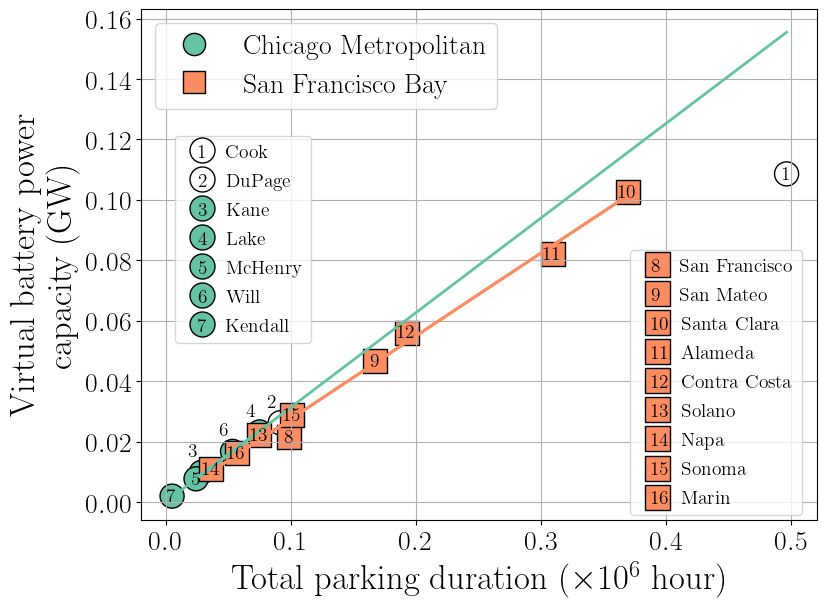

In [11]:
import matplotlib.lines as mlines
# 手动编号每个散点，并在右下角显示编号和 County name 对应关系
plt.figure(figsize=(10, 6.18))

colors = sns.color_palette("Set2")

# Set global font to Times New Roman (if available)
plt.rcParams['text.usetex'] = True

# 设置 Times New Roman 字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

colors_number = ['black', 'black']
# 创建一个编号
numbering = {county: idx + 1 for idx, county in enumerate(df['County name'])}

offsets = {
    2: (-0.007, 0.007),
    3: (-0.007, 0.007),
    4: (-0.007, 0.007),
    5: (0, 0),
    6: (-0.007, 0.007),
}

# Plotting scatter plot with numbers inside the markers
for i, area in enumerate(areas):
    area_data = df[df['Area'] == area]
    
    # Scatter plot for each area with different markers
    if area == 'Chicago Metropolitan':
        fillcolors = ['white', 'white', colors[i], colors[i], colors[i], colors[i], colors[i]]
        scatter = plt.scatter(area_data['Parking total hour'], area_data['Battery power capacity (GW)'], 
                            color=fillcolors, label=area, marker=markers[i], s=300, edgecolor='black')
    else:
        scatter = plt.scatter(area_data['Parking total hour'], area_data['Battery power capacity (GW)'], 
                            color=colors[i], label=area, marker=markers[i], s=300, edgecolor='black')
    
    # Add numbers inside the scatter markers
    for j in range(len(area_data)):
        county_name = area_data['County name'].values[j]
        numer_temp = numbering[county_name]
        if numer_temp in offsets.keys():
            x_offset, y_offset = offsets[numer_temp]
        else:
            x_offset, y_offset = (0, 0)
        plt.text(area_data['Parking total hour'].values[j]+x_offset, area_data['Battery power capacity (GW)'].values[j]+y_offset, 
                    str(numbering[county_name]), fontsize=14, color=colors_number[i], ha='center', va='center')

    # Linear regression fit
    if area != 'Chicago Metropolitan':
        X = area_data['Parking total hour'].values.reshape(-1, 1)
        y = area_data['Battery power capacity (GW)']
        reg = LinearRegression(fit_intercept=False).fit(X, y)
        y_pred = reg.predict(X)
        print (area, reg.coef_, reg.intercept_, r2_score(y, y_pred))
    
    # Plotting the regression line
        plt.plot(area_data['Parking total hour'], y_pred, color=colors[i], linewidth=2)

    if area == 'Chicago Metropolitan':
        # powercapacity_noHC = np.array([123.86392452,  27.49976532])/1000
        # scatter_2 = plt.scatter(area_data['Parking hour total'][:2], powercapacity_noHC, 
        #                     color=colors[i], marker=markers[i], s=300, edgecolor='black', alpha=0.5)

        # for j in range(2):
        #     county_name = area_data['County name'].values[j]
        #     numer_temp = numbering[county_name]
        #     if numer_temp in offsets.keys():
        #         x_offset, y_offset = offsets[numer_temp]
        #     else:
        #         x_offset, y_offset = (0, 0)
            
        #     plt.text(area_data['Parking hour total'].values[j], powercapacity_noHC[j], 
        #             str(numbering[county_name]), fontsize=14, color=colors_number[i], ha='center', va='center')
            

        X = area_data['Parking total hour'].values.reshape(-1, 1)
        y = area_data['Battery power capacity (GW)']
        
        y[:2] = np.array([123.86392452,  27.49976532])/1000
        reg = LinearRegression(fit_intercept=False).fit(X, y)
        y_pred = reg.predict(X)
        # plt.plot(area_data['Parking hour total'], y_pred, color=colors[i], linestyle='--')
        print (area, reg.coef_, reg.intercept_)  


        X = area_data['Parking total hour'].values.reshape(-1, 1)
        y = area_data['Battery power capacity (GW)']
        reg = LinearRegression(fit_intercept=False).fit(X[2:], y[2:])
        y_pred = reg.predict(X)
        print (area, reg.coef_, reg.intercept_, r2_score(y[2:], y_pred[2:]))
        plt.plot(area_data['Parking total hour'], y_pred, color=colors[0], linewidth = 2)

    # else:
    #     X = area_data['Parking hour total'].values.reshape(-1, 1)
    #     y = area_data['Battery power capacity (GW)']
    #     reg = LinearRegression(fit_intercept=False).fit(X[1:], y[1:])
    #     y_pred = reg.predict(X)
        
    #     # Plotting the regression line
    #     plt.plot(area_data['Parking hour total'], y_pred, color=colors[i], linestyle='dashdot')




# Customization
plt.xlabel('Total parking duration (' + r'$\times 10^6$ hour)', fontsize=25)
plt.ylabel('Virtual battery power \n capacity (GW)', fontsize=25)
# plt.title('Scatter Plot with Numbered Markers')


# 示例数据
counties = ["Cook", "DuPage", "Kane", "Lake", "McHenry", "Will", "Kendall", 
                    'San Francisco', 'San Mateo', 'Santa Clara', 'Alameda', 'Contra Costa', 'Solano', 'Napa', 'Sonoma', 'Marin']
numbering = {county: idx + 1 for idx, county in enumerate(counties)}
markers = ['o', 's']  # 圆形和方形 marker
# colors = ['red', 'blue']

# 创建自定义的 legend，带编号的 marker
legend_elements_1 = []
legend_elements_2 = []
for county, num in numbering.items():
    # 根据编号分配不同的 marker 样式
    marker_style = markers[0] if num <= 7 else markers[1]  # 使用圆形或方形 marker
    marker_color = colors[0] if num <= 7 else colors[1]    # 使用红色或蓝色 marker

    if num <= 2:

    # 创建带编号的 marker 并添加到 legend 列表
        marker = mlines.Line2D([], [], color='black', marker=marker_style, markersize=18,
                            markerfacecolor='white', markeredgecolor='black', linewidth=0)
    else:
        marker = mlines.Line2D([], [], color='black', marker=marker_style, markersize=18,
                            markerfacecolor=marker_color, markeredgecolor='black', linewidth=0)
    if num <= 7:
        legend_elements_1.append(marker)
    else:
        legend_elements_2.append(marker)


# plt.show()

labels_legend_1 = []
labels_legend_2 = []
for county, num in numbering.items():
    if num <= 9:
        label_temp = ' ' + f'{num}' + r'$\quad$' + f'{county}'
    else:
        label_temp = ' ' + f'{num}' + r'$\ \ $' + f'{county}'
    if num <= 7:
        labels_legend_1.append(label_temp)
    else:
        labels_legend_2.append(label_temp)


# 绘制图例
# fig, ax = plt.subplots(figsize=(6, 6))
legend_1 = plt.legend(handles=legend_elements_1, labels=labels_legend_1,
                    loc='center', bbox_to_anchor=(0.15, 0.55), borderaxespad=0., fontsize=14,
                    handletextpad=-1.2,  # 控制 marker 和文本之间的水平距离
                    labelspacing=0.6)   # 控制每个图例项之间的垂直距离


legend_2 = plt.legend(handles=legend_elements_2, labels=labels_legend_2,
                    loc='center', bbox_to_anchor=(0.85, 0.27), borderaxespad=0., fontsize=14,
                    handletextpad=-1.3,  # 控制 marker 和文本之间的水平距离
                    labelspacing=0.6)   # 控制每个图例项之间的垂直距离



legend_elements_area = [
    mlines.Line2D([], [], color=colors[0], marker='o', markeredgecolor='black', markersize=16, 
                  label='Chicago Metropolitan', markerfacecolor=colors[0], linewidth=0),
    mlines.Line2D([], [], color=colors[1], marker='s', markeredgecolor='black', markersize=16, 
                  label='San Francisco Bay', markerfacecolor=colors[1],linewidth=0)
]


legend_area = plt.legend(handles=legend_elements_area, loc='upper left', bbox_to_anchor=(0.0, 1), fontsize=20)


plt.gca().add_artist(legend_1)
plt.gca().add_artist(legend_2)



plt.tick_params(axis='both', which='major', labelsize=20)

# Display the plot
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make room for the legend on the right
# plt.savefig('figures/parkHour_vs_VBPC.pdf', format='pdf', bbox_inches='tight')
plt.show()



/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/matplotlib/cbook.py:1072: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


Chicago Metropolitan [1.24130941] 0.0 0.9884234625307996
Chicago Metropolitan [1.24130941] 0.0
San Francisco Bay [1.03310005] 0.0 0.9895292309972215


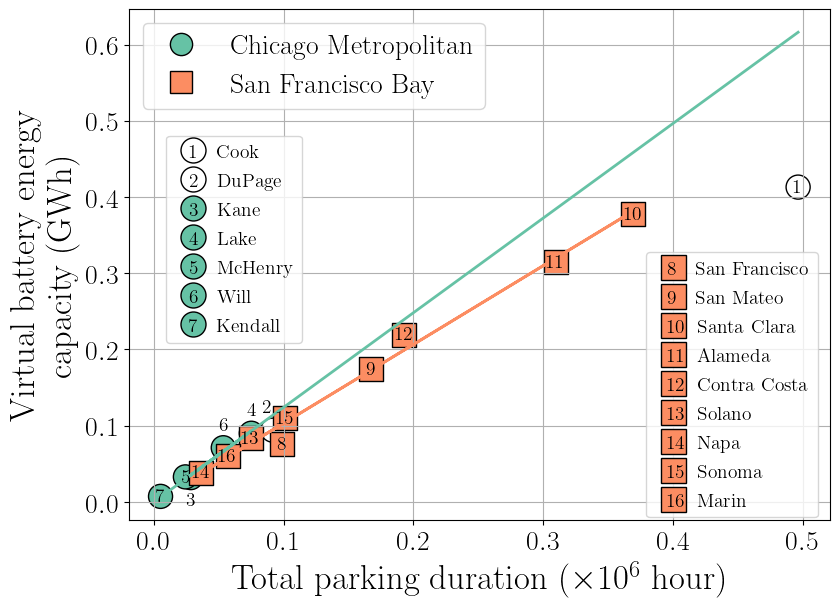

In [7]:
import matplotlib.lines as mlines
# 手动编号每个散点，并在右下角显示编号和 County name 对应关系
plt.figure(figsize=(10, 6.18))

colors = sns.color_palette("Set2")

# Set global font to Times New Roman (if available)
plt.rcParams['text.usetex'] = True

# 设置 Times New Roman 字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

colors_number = ['black', 'black']
# 创建一个编号
numbering = {county: idx + 1 for idx, county in enumerate(df['County name'])}

offsets = {
    2: (-0.005, 0.03),
    3: (0, -0.03),
    4: (0, 0.03),
    5: (0, 0),
    6: (0, 0.03),
}

# Plotting scatter plot with numbers inside the markers
for i, area in enumerate(areas):
    area_data = df[df['Area'] == area]
    
    if area == 'Chicago Metropolitan':
        fillcolors = ['white', 'white', colors[i], colors[i], colors[i], colors[i], colors[i]]
        scatter = plt.scatter(area_data['Parking total hour'], area_data['Battery energy capacity (GWh)'], 
                            color=fillcolors, label=area, marker=markers[i], s=300, edgecolor='black')
    else:
        scatter = plt.scatter(area_data['Parking total hour'], area_data['Battery energy capacity (GWh)'], 
                            color=colors[i], label=area, marker=markers[i], s=300, edgecolor='black')
    
    # Add numbers inside the scatter markers
    for j in range(len(area_data)):
        county_name = area_data['County name'].values[j]
        numer_temp = numbering[county_name]
        if numer_temp in offsets.keys():
            x_offset, y_offset = offsets[numer_temp]
        else:
            x_offset, y_offset = (0, 0)
        
        plt.text(area_data['Parking total hour'].values[j] +x_offset, area_data['Battery energy capacity (GWh)'].values[j] + y_offset, 
                 str(numbering[county_name]), fontsize=14, color=colors_number[i], ha='center', va='center')

    # Linear regression fit
    if area != 'Chicago Metropolitan':
        X = area_data['Parking total hour'].values.reshape(-1, 1)
        y = area_data['Battery energy capacity (GWh)']
        reg = LinearRegression(fit_intercept=False).fit(X, y)
        y_pred = reg.predict(X)
        print (area, reg.coef_, reg.intercept_, r2_score(y, y_pred))
        
        # Plotting the regression line
        plt.plot(area_data['Parking total hour'], y_pred, color=colors[i], linewidth=2)



    if area == 'Chicago Metropolitan':
        X = area_data['Parking total hour'].values.reshape(-1, 1)
        y = area_data['Battery energy capacity (GWh)']
        reg = LinearRegression(fit_intercept=False).fit(X[2:], y[2:])
        y_pred = reg.predict(X)
        print (area, reg.coef_, reg.intercept_, r2_score(y[2:], y_pred[2:]))
        plt.plot(area_data['Parking total hour'], y_pred, color=colors[i], linewidth=2)
        print (area, reg.coef_, reg.intercept_)   


# Customization
plt.xlabel('Total parking duration (' + r'$\times 10^6$ hour)', fontsize=25)
plt.ylabel('Virtual battery energy \n capacity (GWh)', fontsize=25)
# plt.title('Scatter Plot with Numbered Markers')


# 示例数据
counties = ["Cook", "DuPage", "Kane", "Lake", "McHenry", "Will", "Kendall", 
                    'San Francisco', 'San Mateo', 'Santa Clara', 'Alameda', 'Contra Costa', 'Solano', 'Napa', 'Sonoma', 'Marin']
numbering = {county: idx + 1 for idx, county in enumerate(counties)}
markers = ['o', 's']  # 圆形和方形 marker
# colors = ['red', 'blue']

# 创建自定义的 legend，带编号的 marker
legend_elements_1 = []
legend_elements_2 = []
for county, num in numbering.items():
    # 根据编号分配不同的 marker 样式
    marker_style = markers[0] if num <= 7 else markers[1]  # 使用圆形或方形 marker
    marker_color = colors[0] if num <= 7 else colors[1]    # 使用红色或蓝色 marker

    if num <= 2:
        marker = mlines.Line2D([], [], color='black', marker=marker_style, markersize=18,
                                markerfacecolor='white', markeredgecolor='black', linewidth=0)
    else:
        marker = mlines.Line2D([], [], color='black', marker=marker_style, markersize=18,
                        markerfacecolor=marker_color, markeredgecolor='black', linewidth=0)
    if num <= 7:
        legend_elements_1.append(marker)
    else:
        legend_elements_2.append(marker)


# plt.show()

labels_legend_1 = []
labels_legend_2 = []
for county, num in numbering.items():
    if num <= 9:
        label_temp = ' ' + f'{num}' + r'$\quad$' + f'{county}'
    else:
        label_temp = ' ' + f'{num}' + r'$\ \ $' + f'{county}'
    if num <= 7:
        labels_legend_1.append(label_temp)
    else:
        labels_legend_2.append(label_temp)


# 绘制图例
# fig, ax = plt.subplots(figsize=(6, 6))
legend_1 = plt.legend(handles=legend_elements_1, labels=labels_legend_1,
                    loc='center', bbox_to_anchor=(0.15, 0.55), borderaxespad=0., fontsize=14,
                    handletextpad=-1.2,  # 控制 marker 和文本之间的水平距离
                    labelspacing=0.6)   # 控制每个图例项之间的垂直距离


legend_2 = plt.legend(handles=legend_elements_2, labels=labels_legend_2,
                    loc='center', bbox_to_anchor=(0.86, 0.265), borderaxespad=0., fontsize=14,
                    handletextpad=-1.3,  # 控制 marker 和文本之间的水平距离
                    labelspacing=0.6)   # 控制每个图例项之间的垂直距离



legend_elements_area = [
    mlines.Line2D([], [], color=colors[0], marker='o', markeredgecolor='black', markersize=16, 
                  label='Chicago Metropolitan', markerfacecolor=colors[0], linewidth=0),
    mlines.Line2D([], [], color=colors[1], marker='s', markeredgecolor='black', markersize=16, 
                  label='San Francisco Bay', markerfacecolor=colors[1],linewidth=0)
]


legend_area = plt.legend(handles=legend_elements_area, loc='upper left', bbox_to_anchor=(0.0, 1), fontsize=20)


plt.gca().add_artist(legend_1)
plt.gca().add_artist(legend_2)



plt.tick_params(axis='both', which='major', labelsize=20)

# Display the plot
plt.grid(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Make room for the legend on the right
# plt.savefig('figures/parkHour_vs_VBEC.pdf', format='pdf', bbox_inches='tight')
plt.show()



In [18]:
"""load the virtual battery capacity results of the Chicago Metropolitan Area"""
N_t = 96
N_n = 7
N_line = 6 

capacity_county = pd.read_csv('geo/capacity_county_ordered.csv', index_col = 0)['EV_LOAD_CAPACITY_KW'].values/1000 / 56.5 * 1000
peneNum = 10
capacityNum = 10
capacity_scale = np.arange(capacityNum) + 1
peneList = np.linspace(0.1, 1, peneNum)
peneList = [0.05]

ratio_pubCharger_list = np.linspace(0.4, 1, 7)
ratioNum = len(ratio_pubCharger_list)

u_UB_rec = {}
u_LB_rec = {}
E_UB_rec = {}
E_LB_rec = {}
f_UB_rec = {}
f_LB_rec = {}

for i in [0]:
    u_UB_rec[i] = {}
    u_LB_rec[i] = {}
    E_UB_rec[i] = {}
    E_LB_rec[i] = {}
    f_UB_rec[i] = {}
    f_LB_rec[i] = {}
    pene_value = peneList[i]
    path_temp = f'Results/Chicago2017_RealCapacity/VB_VL_realPene/pene={pene_value:.3f}'
    for ratio_pubCharger in ratio_pubCharger_list:
        u_UB_rec[i][ratio_pubCharger] = {}
        u_LB_rec[i][ratio_pubCharger] = {}
        E_UB_rec[i][ratio_pubCharger] = {}
        E_LB_rec[i][ratio_pubCharger] = {}
        f_UB_rec[i][ratio_pubCharger] = {}
        f_LB_rec[i][ratio_pubCharger] = {}
        for j in range(capacityNum):
            u_UB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/u_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()
            u_LB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/u_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()
            E_UB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/E_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()
            E_LB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/E_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()
            f_UB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/f_UB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()
            f_LB_rec[i][ratio_pubCharger][j] = sparse.load_npz(f"{path_temp}/f_LB_ratio={ratio_pubCharger:.1f}_scale={capacity_scale[j]:.1f}.npz").toarray()

            break # only one capacity scale
        break # only one ratio_pubCharger
    break # only one pene_value
           
BatteryPowerCapacity_Chicago_05 = (u_UB_rec[i][ratio_pubCharger][j] - u_LB_rec[i][ratio_pubCharger][j]).mean(axis = 1)/1000 # GW
BatteryEnergyCapacity_Chicago_05 = (E_UB_rec[i][ratio_pubCharger][j] - E_LB_rec[i][ratio_pubCharger][j]).mean(axis = 1)/1000 # GWh

parkHours_Chicago_05 = parkHours_Chicago / 0.011 * 0.05
            

In [28]:
df = {
    "County name": ["Cook", "DuPage", "Kane", "Lake", "McHenry", "Will", "Kendall"],
    "Battery energy capacity (GWh)": BatteryEnergyCapacity_Chicago_05,
    "Parking total hour": parkHours_Chicago_05['total'].values/1e6,
    "Area": ["Chicago Metropolitan"] * 7,
    'Battery power capacity (GW)': BatteryPowerCapacity_Chicago_05,
    'HC_Bind_05': np.array([ True,  True, False,  True, False, False, False]),
}

df = pd.DataFrame(df)

/Users/chen4911/miniconda3/envs/py310/lib/python3.10/site-packages/matplotlib/cbook.py:1072: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


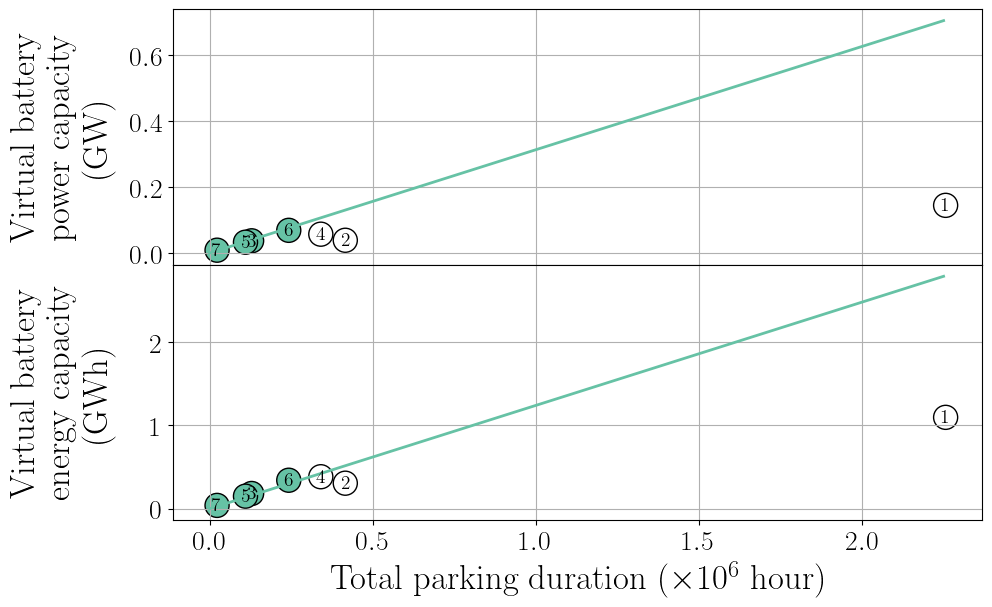

In [42]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.linear_model import LinearRegression

# 设置字体和颜色
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

colors = sns.color_palette("Set2")
colors_number = ['black', 'black']

areas = ['Chicago Metropolitan']

# 创建编号映射
numbering = {county: idx + 1 for idx, county in enumerate(df['County name'])}
offsets = {3: (0.1, -0.02), 5: (-0.1, -0.02), 6: (0.15, -0.02)}

# 创建画布和子图，sharex 确保两个子图共享 x 轴
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6.18), sharex=True, gridspec_kw={'height_ratios': [1, 1], 'hspace': 0})

def plot_area_data(ax, x_column, y_column, bool_column, ylabel, slope):
    """绘制单个子图的函数"""
    for i, area in enumerate(areas):
        area_data = df[df['Area'] == area]
        fillcolors = []
        for j in range(len(area_data)):
            if area_data[bool_column][j]:
                fillcolors.append('white')
            else:
                fillcolors.append(colors[i])
        # 绘制散点图
        scatter = ax.scatter(area_data[x_column], 
                             area_data[y_column], 
                             color=fillcolors, marker=markers[i], s=300, edgecolor='black')

        # 在散点内添加编号
        for j in range(len(area_data)):
            county_name = area_data['County name'].values[j]
            numer_temp = numbering[county_name]
            x_offset, y_offset = offsets.get(numer_temp, (0, 0))

            ax.text(area_data[x_column].values[j], 
                    area_data[y_column].values[j], 
                    str(numer_temp), fontsize=14, color=colors_number[i], 
                    ha='center', va='center')

        # 绘制线性回归拟合线
        X = np.linspace(0, 2.25, 100)
        # reg = LinearRegression(fit_intercept=True).fit(X, y)
        y_pred = X * slope
        ax.plot(X, y_pred, color=colors[i], linewidth=2)

    # 设置 y 轴标签和网格
    ax.set_ylabel(ylabel, fontsize=25)
    ax.yaxis.set_label_coords(-0.07, 0.5)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.grid(True)

# 绘制上方子图
plot_area_data(ax1, 'Parking total hour', 'Battery power capacity (GW)', 'HC_Bind_05',
               'Virtual battery \n power capacity \n (GW)', 0.31328743)
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # 隐藏上方子图的 x 轴


# 绘制下方子图
plot_area_data(ax2, 'Parking total hour', 'Battery energy capacity (GWh)', 'HC_Bind_05',
               'Virtual battery \n energy capacity \n (GWh)', 1.24130941)
ax2.set_xlabel('Total parking duration (' + r'$\times 10^6$ hour)', fontsize=25)





# 调整布局并显示图像
plt.tight_layout()
plt.savefig('figures/parkHour_vs_VBC_pene=05.pdf', format='pdf', bbox_inches='tight')
plt.show()
